In [0]:
from google.colab import drive
import os

if os.path.exists('/content/gdrive')==False:
  drive.mount('/content/gdrive')
  print('Google Drive is mounted\n')
else:
  print('Google Drive is already mounted\n')

Google Drive is already mounted



Found 2180 images belonging to 5 classes.
Found 210 images belonging to 5 classes.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 24, 24, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 12, 12, 64)   9472        input_6[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 12, 12, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_111 (Activation)     (None, 12, 12, 64)   0           bn_conv1[0][0]                   
__________________________

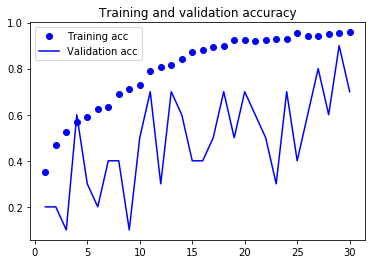

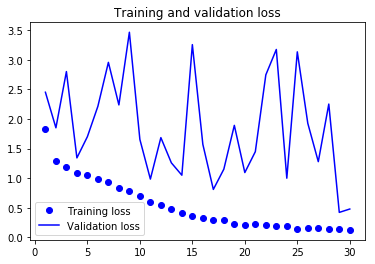

-- Predict --
[[0.000 0.846 0.154 0.001 0.000]
 [0.987 0.001 0.011 0.002 0.000]
 [0.000 0.000 0.998 0.002 0.000]
 [0.001 0.003 0.995 0.000 0.000]
 [0.775 0.000 0.013 0.212 0.000]
 [0.000 0.984 0.000 0.000 0.016]
 [0.000 0.033 0.962 0.000 0.005]
 [0.000 0.002 0.015 0.983 0.000]
 [0.000 1.000 0.000 0.000 0.000]
 [0.001 0.050 0.940 0.001 0.008]]


In [0]:
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(777)

from keras.preprocessing.image import ImageDataGenerator

# 데이터셋 불러오기
train_datagen = ImageDataGenerator(rescale=1./255
                                  ) 


train_generator = train_datagen.flow_from_directory(
        '/content/gdrive/My Drive/Colab Notebooks/house/handwriting_shape/train',
        target_size=(24, 24),
        batch_size=2,
        class_mode='categorical') # trian data

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/content/gdrive/My Drive/Colab Notebooks/house/handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=2,
        class_mode='categorical') #test data
   
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization, AveragePooling2D
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.applications import ResNet50
classes = 5
filter_size = 16  # 필터 개수
kernel_size = (3,3) # 필터 사이즈
pool_size = (2,2)
input_shape = (24,24,3)
def getModel(input_shape):
  classes = 5
  filter_size = 16  # 필터 개수
  kernel_size = (3,3) # 필터 사이즈
  pool_size = (2,2)
  m = Sequential()
  
  def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    
    conv_name_base = 'res' + str(stage) + block +  '_branch'
    bn_name_base = 'bn' + str(stage) + block +  '_branch'
    
    x = Conv2D(filters1, (1,1), name = conv_name_base +'2a')(input_tensor)
    x = BatchNormalization(name = bn_name_base+'2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,padding='same',name = conv_name_base+'2b')(x)
    x = BatchNormalization(name = bn_name_base +'2b')(x)
    x = Activation('relu')(x)
    
    
    x = Conv2D(filters3,(1,1),name = conv_name_base+'2c')(x)
    x = BatchNormalization(name = bn_name_base +'2c')(x)
    
    x = layers.add([x,input_tensor])
    x = Activation('relu')(x)
    
    return x
  
  def conv_block(input_tensor,kernel_size, filters,stage, block,strides=(2,2)):
    filters1, filters2 , filters3 = filters
    conv_name_base = 'res' + str(stage)+block+'_branch'
    bn_name_base = 'bn' +str(stage) +block+'_branch'
    
    x = Conv2D(filters1, (1,1),strides = strides, name = conv_name_base +'2a')(input_tensor)
    x = BatchNormalization(name = bn_name_base +'2a')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters2, kernel_size,padding = 'same', name = conv_name_base +'2b')(x)
    x = BatchNormalization(name = bn_name_base+'2b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters3,(1,1), name = conv_name_base +'2c')(x)
    x = BatchNormalization(name = bn_name_base+'2c')(x)
    
    shortcut = Conv2D(filters3, (1,1), strides = strides, name = conv_name_base+'1')(input_tensor)
    shortcut = BatchNormalization(name = bn_name_base+'1')(shortcut)
    
    x = layers.add([x,shortcut])
    x = Activation('relu')(x)
    
    return x
  
  i = Input(shape = input_shape)
  x = Conv2D(64, (7,7),strides = (2,2), padding = 'same', name = 'conv1')(i)
  x = BatchNormalization(name = 'bn_conv1')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((3,3), strides =(2,2))(x)
  
  x = conv_block(x,3,[64,64,256],stage = 2 , block = 'a', strides =(1,1))
  x = identity_block(x,3,[64,64,256], stage = 2, block = 'b')
  x = identity_block(x,3,[64,64,256], stage = 2, block = 'c')
  x = conv_block(x,3,[128,128,512], stage = 3, block = 'a')
  x = identity_block(x,3,[128,128,512], stage = 3, block = 'b')
  x = identity_block(x,3,[128,128,512], stage = 3, block = 'c')
  x = identity_block(x,3,[128,128,512], stage = 3, block = 'd')
  
  x = AveragePooling2D((2,2), name = 'avg_pool')(x)
  
  x = Flatten()(x)
  x = Dense(classes,activation = "softmax", name = "softmax")(x)
  
  
  return Model(i,x, name = 'Resnet')


    
    
    







m = getModel(input_shape)



m.summary() #모델에 대한 정보 출력

  

# 모델 엮기
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습시키기
history = m.fit_generator(
         train_generator,
        steps_per_epoch = 1000,
        epochs=30, validation_data = test_generator, validation_steps = 5
       )

# 모델 평가하기
print("-- Evaluate --")

scores = m.evaluate_generator(
            test_generator, 
            steps = 5)

print("%s: %.2f%%" %(m.metrics_names[1], scores[1]*100))
# 훈련의 정확도, 손실 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss =  history.history['loss']
val_loss =  history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 모델 예측하기
print("-- Predict --")

output = m.predict_generator(
            test_generator, 
            steps = 5)

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(output)

In [0]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix


import numpy as np
from keras.preprocessing import image

import matplotlib.pyplot as plt

img_width, img_height  =24, 24

validation_datagen = ImageDataGenerator(
      rescale=1./255,
      )

# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
       '/content/gdrive/My Drive/Colab Notebooks/house/handwriting_shape/test',#경로 validation으로 수정하기
        target_size=(img_width, img_height),
        batch_size=10,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = m.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = image.load_img('{}/{}'.format('/content/gdrive/My Drive/Colab Notebooks/house/handwriting_shape/test',fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

cm = confusion_matrix(ground_truth, predicted_classes)
cm

TruePositive = np.diag(cm)
print("TP is" + str(TruePositive) )

FalsePositive = []
for i in range(5):
    FalsePositive.append(sum(cm[:,i]) - cm[i,i])

print("FP is" + str(FalsePositive) )
        
FalseNegative = []
for i in range(5):
    FalseNegative.append(sum(cm[i,:]) - cm[i,i])
    
print("FN is" + str(FalseNegative) )

TrueNegative = []
for i in range(5):
    temp = np.delete(cm, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))
   
print("TN is" + str(TrueNegative) )   